In [2]:
from faiss import IndexFlatIP, IndexFlat
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn
import tqdm
import pandas

In [3]:
!pip install git+https://github.com/cat-state/clip_benchmark

  Cloning https://github.com/cat-state/clip_benchmark to /tmp/pip-req-build-xb4vgc_3
  Running command git clone --filter=blob:none --quiet https://github.com/cat-state/clip_benchmark /tmp/pip-req-build-xb4vgc_3
  Resolved https://github.com/cat-state/clip_benchmark to commit 0e9180ad09e1e96d55d75ef30d11c08e98122219
  Preparing metadata (setup.py) ... done
  Created wheel for clip-benchmark: filename=clip_benchmark-0.0.1-py3-none-any.whl size=4463 sha256=25a8012351f881f5097615294b42f43742a67cb0ba6b61e1f673e5a293d57295
  Stored in directory: /tmp/pip-ephem-wheel-cache-65gwdehm/wheels/6d/7c/45/0651c639acd92a60811123532aa423a3b36315dd1ebb29a009
Successfully built clip-benchmark
You should consider upgrading via the '/home/cat/mambaforge/envs/tangle/bin/python3.9 -m pip install --upgrade pip' command.


In [24]:
!git lfs install
!git clone https://huggingface.co/datasets/cat-state/clip-embeddings || true

Updated Git hooks.
Git LFS initialized.
fatal: destination path 'clip-embeddings' already exists and is not an empty directory.


In [4]:
models = {
    'openclip ViT-B-16': dict(img_embeds=np.load('clip-embeddings/coco-embeds-open-clip-vit-b-16/img_emb/img_emb_0.npy'),
                              text_embeds=np.load('clip-embeddings/coco-embeds-open-clip-vit-b-16/text_emb/text_emb_0.npy')),
    
    'openclip ViT-B-32': dict(img_embeds=np.load('clip-embeddings/coco-embeds-open-clip-vit-b-32/img_emb/img_emb_0.npy'),
                              text_embeds=np.load('clip-embeddings/coco-embeds-open-clip-vit-b-32/text_emb/text_emb_0.npy')),

    'cloob ViT-B-16': dict(img_embeds=np.load('clip-embeddings/cloob-vit-b-16/cloob_laion_400m_vit_b_16_32_epochs_coco_train2017_image_embeds.npy'),
                           text_embeds=np.load('clip-embeddings/cloob-vit-b-16/cloob_laion_400m_vit_b_16_32_epochs_coco_train2017_text_embeds.npy')),
    
    'ml_jku_cloob_infoNCE': dict(img_embeds=np.load("clip-embeddings/ml_jku_cloob_embeddings/cloob_infoNCE_rn50_cc_epoch_128_image_embeds.npy"),
                            text_embeds=np.load("clip-embeddings/ml_jku_cloob_embeddings/cloob_infoNCE_rn50_cc_epoch_128_text_embeds.npy")),

    'ml_jku_clip_rn50': dict(img_embeds=np.load("clip-embeddings/ml_jku_cloob_embeddings/clip30_rn50_cc_epoch_128_image_embeds.npy"),
                        text_embeds=np.load("clip-embeddings/ml_jku_cloob_embeddings/clip30_rn50_cc_epoch_128_text_embeds.npy")),

    'ml_jku_clip_infoLOOB': dict(img_embeds=np.load("clip-embeddings/ml_jku_cloob_embeddings/clip_infoLOOB_rn50_cc_epoch_128_image_embeds.npy"),
                            text_embeds=np.load("clip-embeddings/ml_jku_cloob_embeddings/clip_infoLOOB_rn50_cc_epoch_128_text_embeds.npy")),

    'ml_jku_cloob_rn50': dict(img_embeds=np.load("clip-embeddings/ml_jku_cloob_embeddings/cloob_rn50_cc_epoch_128_image_embeds.npy"),
                         text_embeds=np.load("clip-embeddings/ml_jku_cloob_embeddings/cloob_rn50_cc_epoch_128_text_embeds.npy")),

}

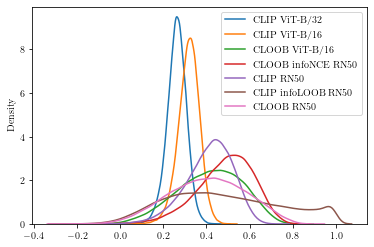

In [25]:
for embeds, name in [(models['openclip ViT-B-32'], "CLIP ViT-B/32"),
                     (models['openclip ViT-B-16'], "CLIP ViT-B/16"),
                     (models['cloob ViT-B-16'], "CLOOB ViT-B/16"),
                     (models['ml_jku_cloob_infoNCE'], "CLOOB infoNCE RN50"),
                     (models['ml_jku_clip_rn50'], "CLIP RN50"),
                     (models['ml_jku_clip_infoLOOB'], "CLIP infoLOOB RN50"),
                     (models['ml_jku_cloob_rn50'], "CLOOB RN50")]:
    seaborn.kdeplot((embeds["img_embeds"] * embeds["text_embeds"]).sum(axis=-1), label=name)
plt.gcf().set(facecolor="white")
plt.legend()

In [7]:
from clip_benchmark import cross_modal_retrieval

In [9]:
results = []
for embeds, name in tqdm.tqdm(
    [(models['openclip ViT-B-32'], "CLIP ViT-B/32"),
                     (models['openclip ViT-B-16'], "CLIP ViT-B/16"),
                     (models['cloob ViT-B-16'], "CLOOB ViT-B/16"),
                     (models['ml_jku_cloob_infoNCE'], "CLOOB infoNCE RN50"),
                     (models['ml_jku_clip_rn50'], "CLIP RN50"),
                     (models['ml_jku_clip_infoLOOB'], "CLIP infoLOOB RN50"),
                     (models['ml_jku_cloob_rn50'], "CLOOB RN50")]):
    subset = 5000
    img_embeds = embeds["img_embeds"][:subset]
    txt_embeds = embeds["text_embeds"][:subset]
    results.append({**cross_modal_retrieval(img_embeds, txt_embeds), "name": name})


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:14<00:00,  2.08s/it]


In [10]:
import pandas
results = pandas.DataFrame(results)

In [17]:
results["text->img @1"] = results["text->img"].apply(lambda x: x[:, :5].any(-1).sum() / subset)
results["img->text @1"] = results["img->text"].apply(lambda x: x[:, :5].any(-1).sum() / subset)
results["text->img @5"] = results["text->img"].apply(lambda x: x[:, :5].any(-1).sum() / subset)
results["img->text @5"] = results["img->text"].apply(lambda x: x[:, :5].any(-1).sum() / subset)

In [19]:
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

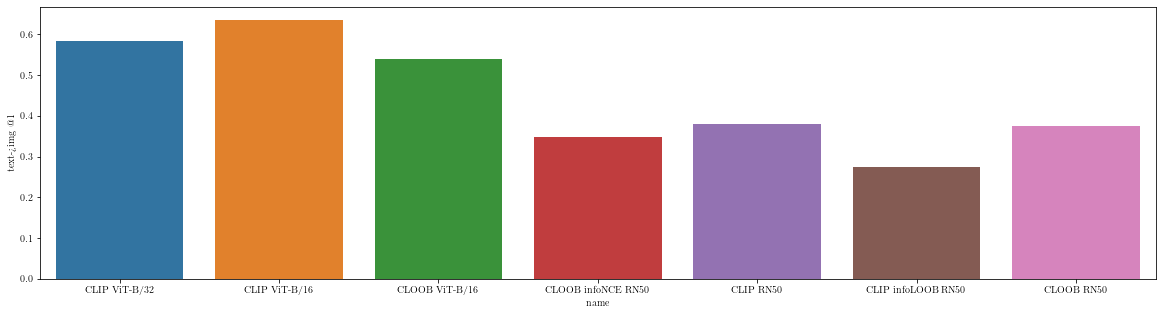

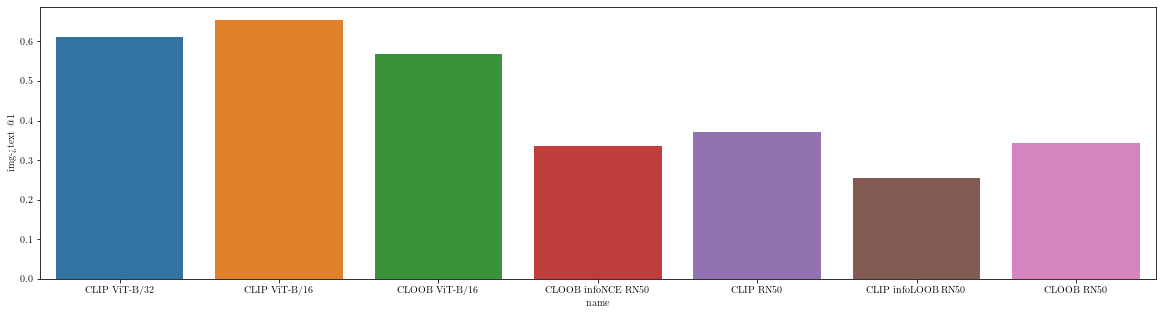

In [22]:
plt.figure(figsize=(20, 5), facecolor="white")
seaborn.barplot(data=results, x="name", y="text->img @1")
plt.savefig("figures/text->img retrieval @1.png")
plt.show()
plt.figure(figsize=(20, 5), facecolor="white")
seaborn.barplot(data=results, x="name", y="img->text @1")
plt.savefig("figures/img->text retrieval @1.png")


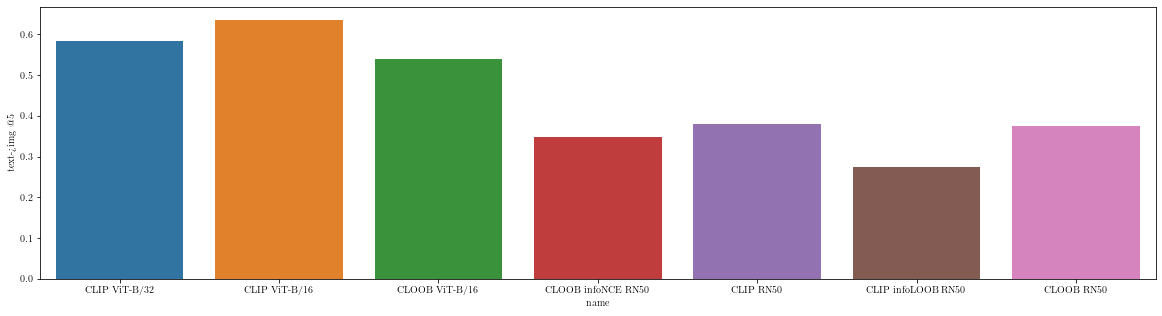

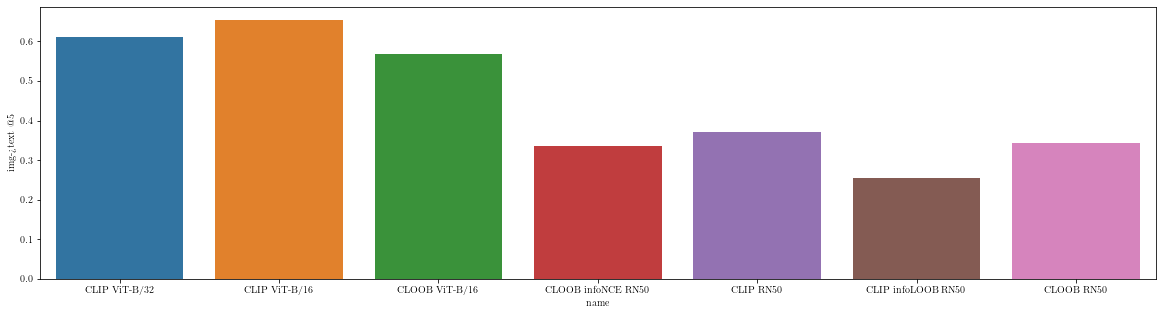

In [23]:
plt.figure(figsize=(20, 5), facecolor="white")
seaborn.barplot(data=results, x="name", y="text->img @5")
plt.savefig("figures/text->img retrieval @5.png")
plt.show()
plt.figure(figsize=(20, 5), facecolor="white")
seaborn.barplot(data=results, x="name", y="img->text @5")
plt.savefig("figures/img->text retrieval @5.png")
